# Detectron2 + DocLayNet Dataset

## Setup the configuration for training the Detectron2 model

In [1]:
import torch
import detectron2

# Import common libraries
import numpy as np
import os
import matplotlib.pyplot as plt

# Import tools from Detectron2 library
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

# Setup Detectron2 logger
setup_logger()

<Logger detectron2 (DEBUG)>

## Get the dataset annoatations in COCO format

In [2]:
from pycocotools.coco import COCO

path = "/home/alex/Datasets/DocLayNet/DocLayNet_core/"
path_to_coco_train = path + "COCO/train.json"
path_to_coco_test = path + "COCO/test.json"
path_to_coco_val = path + "COCO/val.json"

train_coco = COCO(path_to_coco_train)
test_coco = COCO(path_to_coco_test)
val_coco = COCO(path_to_coco_val)

loading annotations into memory...
Done (t=6.60s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [3]:
classes = [i["name"] for i in train_coco.loadCats(train_coco.getCatIds())]
len(classes)

11

## Preprocess the data for the Detectron2 model training

In [4]:
def get_dicts(ds_coco):
    dataset_dicts = []
    for image_id in ds_coco.getImgIds():
        record = {}

        image_info = ds_coco.loadImgs(image_id)[0]
        img_dir = "/home/alex/Datasets/DocLayNet/DocLayNet_core/PNG/"
        record["file_name"] = os.path.join(img_dir, image_info["file_name"])
        record["image_id"] = image_info["id"]
        record["height"] = image_info["height"]
        record["width"] = image_info["width"]

        objs = []
        for annotation in ds_coco.loadAnns(ds_coco.getAnnIds(image_id)):
            obj = {
                "bbox": annotation["bbox"],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": annotation["category_id"] - 1,
            }
            # if obj["category_id"] == 11:
            #     print(image_id)
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


train_dataset = get_dicts(train_coco)
test_dataset = get_dicts(test_coco)
val_dataset = get_dicts(val_coco)

In [5]:
def register_doclaynet(name, dataset_dicts):
    DatasetCatalog.register(name, lambda: dataset_dicts)
    MetadataCatalog.get(name).set(thing_classes=classes)


register_doclaynet("train", train_dataset)
register_doclaynet("test", test_dataset)
register_doclaynet("val", val_dataset)

In [6]:
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
)
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
)
cfg.MODEL.DEVICE = "cuda"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00001
cfg.SOLVER.MAX_ITER = 85000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
# cfg.MODEL.MASK_ON = True

cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

## Train the model

In [7]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/23 15:52:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (44, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (44,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[08/23 15:52:56 d2.engine.train_loop]: Starting training from iteration 0


/home/alex/Projects/Detectron2_DocLayNet/.venv/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/23 15:53:04 d2.utils.events]:  eta: 7:14:46  iter: 19  total_loss: 10.6  loss_cls: 2.407  loss_box_reg: 0.4918  loss_rpn_cls: 6.817  loss_rpn_loc: 0.7638    time: 0.3087  last_time: 0.4137  data_time: 0.0108  last_data_time: 0.0045   lr: 1.9981e-07  max_mem: 2221M
[08/23 15:53:13 d2.utils.events]:  eta: 8:59:16  iter: 39  total_loss: 9.985  loss_cls: 2.388  loss_box_reg: 0.6024  loss_rpn_cls: 6.228  loss_rpn_loc: 0.7895    time: 0.3743  last_time: 0.3768  data_time: 0.0047  last_data_time: 0.0045   lr: 3.9961e-07  max_mem: 2224M
[08/23 15:53:21 d2.utils.events]:  eta: 9:41:30  iter: 59  total_loss: 9.876  loss_cls: 2.374  loss_box_reg: 0.5355  loss_rpn_cls: 6.169  loss_rpn_loc: 0.7896    time: 0.3933  last_time: 0.4082  data_time: 0.0047  last_data_time: 0.0050   lr: 5.9941e-07  max_mem: 2236M
[08/23 15:53:30 d2.utils.events]:  eta: 9:46:44  iter: 79  total_loss: 8.903  loss_cls: 2.347  loss_box_reg: 0.5875  loss_rpn_cls: 5.312  loss_rpn_loc: 0.631    time: 0.3993  last_time: 0.416

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

[08/23 23:33:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/alex/Projects/Detectron2_DocLayNet/.venv/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(

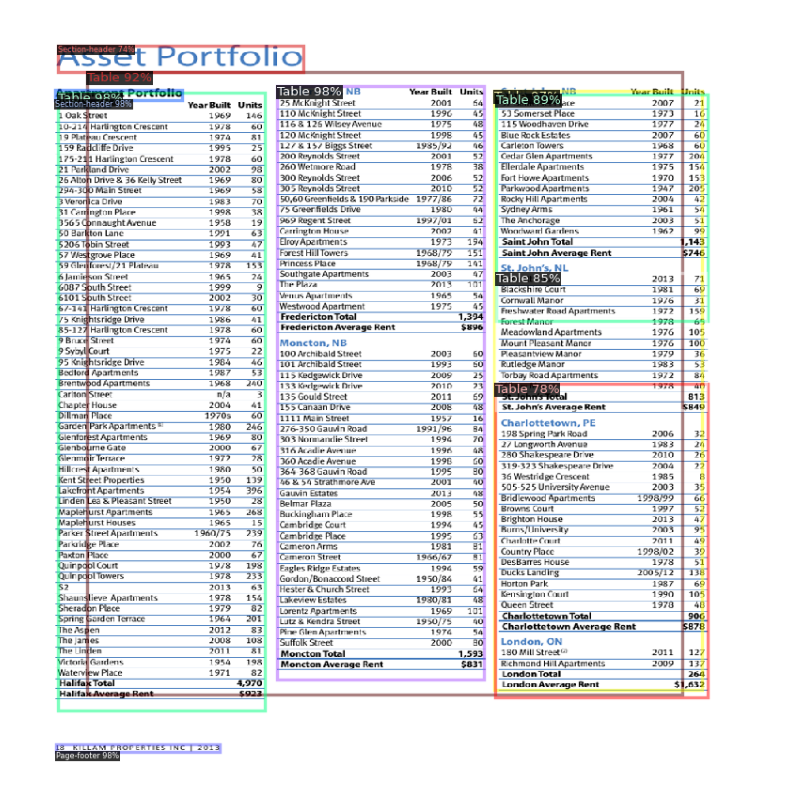

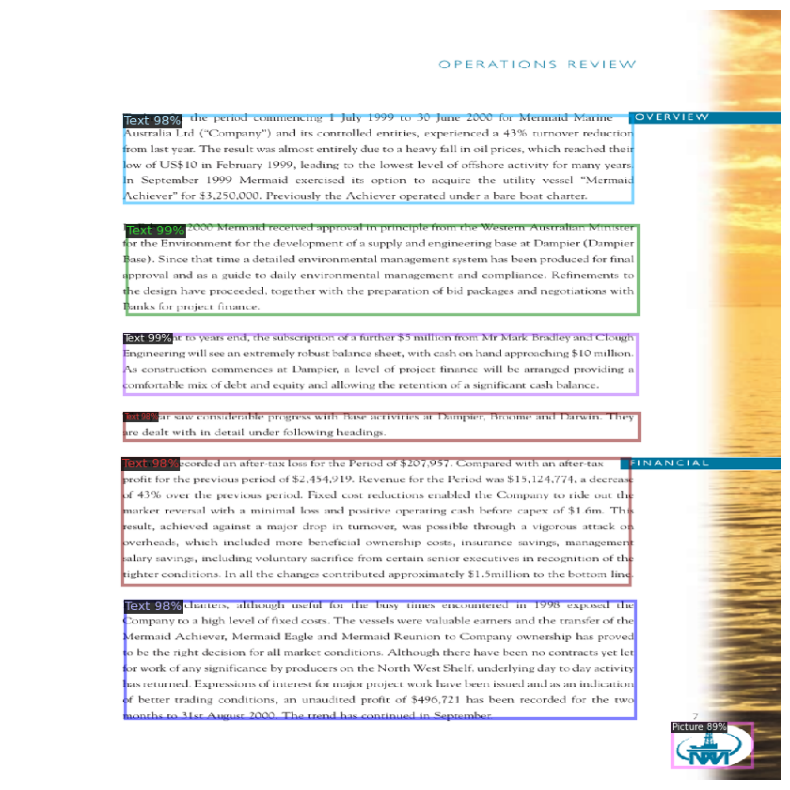

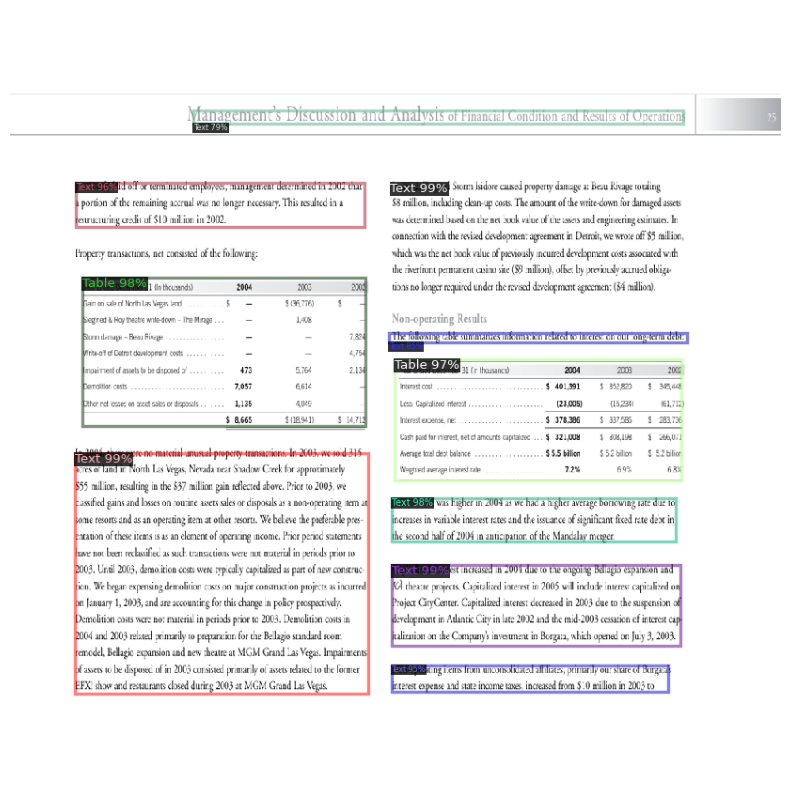

In [19]:
import random
import cv2

dataset_dicts = test_dataset
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("train"), scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [20]:
# im = cv2.imread("test.png")
# outputs = predictor(im)
# v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("train"), scale=0.8)
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# plt.figure(figsize=(14, 10))
# plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.show()

In [11]:
print(cfg.dump())

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_SQRT: true
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - test
  TRAIN:
  - train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_re

In [12]:
with open("config.yml", "w") as f:
    f.write(cfg.dump())

In [16]:
metadata = MetadataCatalog.get("train")
metadata.as_dict

<bound method Metadata.as_dict of Metadata(name='train', thing_classes=['Caption', 'Footnote', 'Formula', 'List-item', 'Page-footer', 'Page-header', 'Picture', 'Section-header', 'Table', 'Text', 'Title'])>

In [17]:
import json

with open("metadata.json", "w") as f:
    json.dump(metadata.as_dict(), f)